In [2]:
# !pip install xgboost_ray
# !pip install "ray[all]" sklearn

In [ ]:
# !pip install xgboost, pickle

In [1]:
import xgboost as xgb   # model training
from xgboost.sklearn import XGBClassifier
import pickle           # save model
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn import metrics   # Additional scklearn functions

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

ref: https://blog.csdn.net/han_xiaoyang/article/details/52665396

In [5]:
%run 102-data_preprocessing.py

(16760, 104) (16760, 1)
(2394, 104) (2394, 1)


# Clean: Imbalanced Data

In [6]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler()
x_over, y_over = oversample.fit_resample(X_train_t1, y_train_t1)

X_train_t1 = pd.DataFrame(x_over)
y_train_t1 = pd.DataFrame(y_over)

: 

In [4]:
# X_valid_t1 = X_valid_t1
X_test_t1 = pd.DataFrame(X_test_t1)

NameError: name 'X_test_t1' is not defined

In [7]:
xgb_params = {
    'learning_rate':0.1,
    'n_estimators':1000,
    'max_depth':14,
    'min_child_weight':1,
    'gamma':0.0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'scale_pos_weight':1,
    # 'tree_method':'gpu_hist', # if you have GPU and not using macOS, use this to speed up training
    # 'predictor':'gpu_predictor', 
    # 'sampling_method': 'gradient_based', 
    'objective':'binary:logistic',
    'seed':3612
}

# Optimization

In [8]:
def model_fit(model: xgb.XGBClassifier or xgb.XGBRegressor, 
              X: pd.DataFrame or np.array or list, 
              y: pd.DataFrame or np.array or list, 
              useTrainCV=True,
              cv_folds=5,
              early_stopping_rounds=50
              ) -> xgb.XGBClassifier or xgb.XGBRegressor:
    
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        xgtrain = xgb.DMatrix(X.values, label=y.values)
        cvresult = xgb.cv(xgb_param, 
                          xgtrain, 
                          num_boost_round=model.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics='auc', 
                          early_stopping_rounds=early_stopping_rounds,
                          verbose_eval=True
                          )
        model.set_params(n_estimators=cvresult.shape[0])

    # fit the algorithm on the data
    model.fit(X, y, eval_metric='auc')
    
    # predict training set
    dtrain_predictions = model.predict(X)
    dtrain_predprob = model.predict_proba(X)[:,1]
    
    # print model report
    print('*'*10)
    print("Model Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
    print('*'*10)
    
    sns.set_style('whitegrid')
    feat_imp = (pd.Series(model.get_booster().get_fscore())
                .sort_values(ascending=False))
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    return model

## 1 - Confirm the parameters by cross-validation

[0]	train-auc:0.97329+0.00138	test-auc:0.93940+0.00079
[1]	train-auc:0.98772+0.00316	test-auc:0.97153+0.00551
[2]	train-auc:0.99354+0.00236	test-auc:0.98295+0.00357
[3]	train-auc:0.99684+0.00103	test-auc:0.98998+0.00180
[4]	train-auc:0.99822+0.00067	test-auc:0.99324+0.00120
[5]	train-auc:0.99868+0.00047	test-auc:0.99447+0.00102
[6]	train-auc:0.99899+0.00031	test-auc:0.99531+0.00082
[7]	train-auc:0.99936+0.00015	test-auc:0.99661+0.00041
[8]	train-auc:0.99958+0.00009	test-auc:0.99723+0.00039
[9]	train-auc:0.99971+0.00008	test-auc:0.99786+0.00033
[10]	train-auc:0.99982+0.00003	test-auc:0.99843+0.00021
[11]	train-auc:0.99987+0.00002	test-auc:0.99866+0.00015
[12]	train-auc:0.99988+0.00003	test-auc:0.99879+0.00020
[13]	train-auc:0.99990+0.00003	test-auc:0.99898+0.00017
[14]	train-auc:0.99992+0.00003	test-auc:0.99907+0.00016
[15]	train-auc:0.99993+0.00003	test-auc:0.99921+0.00021
[16]	train-auc:0.99994+0.00003	test-auc:0.99923+0.00017
[17]	train-auc:0.99995+0.00002	test-auc:0.99933+0.00018
[1

/Users/Artorius/Programming/venv/lib/python3.10/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


**********
Model Report
Accuracy : 1
AUC Score (Train): 1.000000
**********


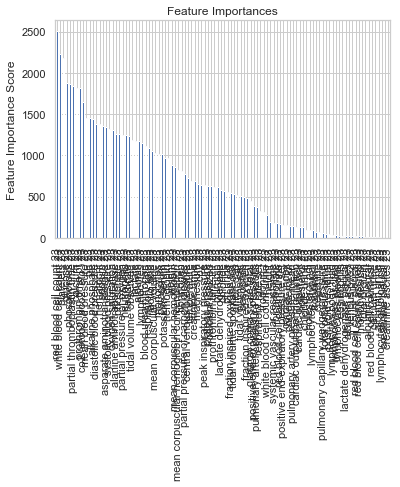

In [38]:
xgb1 = XGBClassifier(**xgb_params)

xgb2 = model_fit(xgb1, X_train_t1, y_train_t1)

In [39]:
print('best n_estimators:', xgb2.get_params()['n_estimators'])
print('best max_depth:', xgb2.get_params()['max_depth'])
print('best min_child_weight:', xgb2.get_params()['min_child_weight'])
print('best gamma:', xgb2.get_params()['gamma'])
print('best subsample:', xgb2.get_params()['subsample'])
print('best colsample_bytree:', xgb2.get_params()['colsample_bytree'])

best n_estimators: 104
best max_depth: 15
best min_child_weight: 1
best gamma: 0.0
best subsample: 0.8
best colsample_bytree: 0.1


In [11]:
xgb_params['n_estimators'] = xgb2.get_params()['n_estimators']

best n_estimators: 261
best max_depth: 14
best min_child_weight: 1
best gamma: 0.0
best subsample: 0.8
best colsample_bytree: 0.8

## 2 - Optimize `max_depth` and `min_child_weight` by grid search

In [12]:
param_test1 = {
 'max_depth':[5,6,7,8,9,11,13,14,15,16,17], # range(3,12,2)
 'min_child_weight': [1,2,3,4,5,6,7] # range(1,6,2)
}

gsearch1 = HalvingGridSearchCV(estimator = XGBClassifier(**xgb_params),
                               param_grid = param_test1, 
                               scoring='roc_auc', 
                               n_jobs=4, 
                               cv=5
                               )

gsearch1.fit(X_train_t1.values, y_train_t1.values.ravel())

HalvingGridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.0,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, m...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=14,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=301, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...),
                    n_jobs=4,
                    param_grid={'max_depth': [5, 6, 7, 8, 9, 11, 13, 14, 15, 16,
                                              17],
                                'min_child_weight': [1, 2, 3, 4, 5, 6, 7]},
                    scoring='roc_auc')

In [13]:
means = gsearch1.cv_results_["mean_test_score"]
stdevs = gsearch1.cv_results_["std_test_score"]
params = gsearch1.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print(gsearch1.best_score_, gsearch1.best_params_)

0.884480 (0.042469) with: {'max_depth': 5, 'min_child_weight': 1}
0.882422 (0.043545) with: {'max_depth': 5, 'min_child_weight': 2}
0.875419 (0.047099) with: {'max_depth': 5, 'min_child_weight': 3}
0.871297 (0.045543) with: {'max_depth': 5, 'min_child_weight': 4}
0.870842 (0.046559) with: {'max_depth': 5, 'min_child_weight': 5}
0.871078 (0.044649) with: {'max_depth': 5, 'min_child_weight': 6}
0.870570 (0.042413) with: {'max_depth': 5, 'min_child_weight': 7}
0.887543 (0.038463) with: {'max_depth': 6, 'min_child_weight': 1}
0.882618 (0.041821) with: {'max_depth': 6, 'min_child_weight': 2}
0.877908 (0.043542) with: {'max_depth': 6, 'min_child_weight': 3}
0.876017 (0.046212) with: {'max_depth': 6, 'min_child_weight': 4}
0.873156 (0.054427) with: {'max_depth': 6, 'min_child_weight': 5}
0.873919 (0.045149) with: {'max_depth': 6, 'min_child_weight': 6}
0.868833 (0.043399) with: {'max_depth': 6, 'min_child_weight': 7}
0.882894 (0.044482) with: {'max_depth': 7, 'min_child_weight': 1}
0.879433 (

In [14]:
xgb_params['max_depth'] = gsearch1.best_params_['max_depth']
xgb_params['min_child_weight'] = gsearch1.best_params_['min_child_weight']

0.9997171254585673

## 3 - Optimize `gamma` by grid search

In [15]:
param_test3 = {
    'gamma': [i/10.0 for i in range(0,6)]
}

gsearch3 = HalvingGridSearchCV(estimator = XGBClassifier(**xgb_params), 
                                param_grid = param_test3, 
                                scoring='roc_auc', 
                                n_jobs=4,
                                cv=5)

gsearch3.fit(X_train_t1.values, y_train_t1.values.ravel())

HalvingGridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.0,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=15,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=301, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...),
                    n_jobs=4,
                    param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]},
                    scoring='roc_auc')

In [16]:
means = gsearch3.cv_results_["mean_test_score"]
stdevs = gsearch3.cv_results_["std_test_score"]
params = gsearch3.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print(gsearch3.best_params_, gsearch3.best_score_)

0.993240 (0.002069) with: {'gamma': 0.0}
0.993273 (0.001774) with: {'gamma': 0.1}
0.992513 (0.001932) with: {'gamma': 0.2}
0.992459 (0.002230) with: {'gamma': 0.3}
0.991893 (0.002039) with: {'gamma': 0.4}
0.991959 (0.002396) with: {'gamma': 0.5}
0.999554 (0.000151) with: {'gamma': 0.0}
0.999508 (0.000160) with: {'gamma': 0.1}
{'gamma': 0.0} 0.9995540883421541


In [17]:
xgb_params['gamma'] = gsearch3.best_params_['gamma']

0.9995540883421541

## 4 - Optimize `subsample` and `colsample_bytree` by grid search

In [18]:
param_test4 = {
    'colsample_bytree':[i/10.0 for i in range(1,10,1)],
    'subsample':[i/10.0 for i in range(1,10,1)]
}

gsearch4 = HalvingGridSearchCV(estimator = XGBClassifier(**xgb_params),
                               param_grid = param_test4, 
                               scoring='roc_auc',
                               n_jobs=4,
                               cv=5
                               )

gsearch4.fit(X_train_t1.values, y_train_t1.values.ravel())

HalvingGridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.0,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, m...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=15,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=301, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...),
                    n_jobs=4,
                    param_grid={'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5,
                                                     0.6, 0.7, 0.8, 0.9],
                                'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                              0.8, 0.9]},
                    scoring='roc_auc')

In [19]:
means = gsearch4.cv_results_["mean_test_score"]
stdevs = gsearch4.cv_results_["std_test_score"]
params = gsearch4.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print(gsearch4.best_score_, gsearch4.best_params_)

0.790052 (0.069715) with: {'colsample_bytree': 0.1, 'subsample': 0.1}
0.819794 (0.053144) with: {'colsample_bytree': 0.1, 'subsample': 0.2}
0.813620 (0.031374) with: {'colsample_bytree': 0.1, 'subsample': 0.3}
0.822235 (0.034881) with: {'colsample_bytree': 0.1, 'subsample': 0.4}
0.828205 (0.026511) with: {'colsample_bytree': 0.1, 'subsample': 0.5}
0.830014 (0.029268) with: {'colsample_bytree': 0.1, 'subsample': 0.6}
0.839213 (0.035482) with: {'colsample_bytree': 0.1, 'subsample': 0.7}
0.831688 (0.028005) with: {'colsample_bytree': 0.1, 'subsample': 0.8}
0.823202 (0.021202) with: {'colsample_bytree': 0.1, 'subsample': 0.9}
0.810454 (0.042105) with: {'colsample_bytree': 0.2, 'subsample': 0.1}
0.824205 (0.040899) with: {'colsample_bytree': 0.2, 'subsample': 0.2}
0.809593 (0.031701) with: {'colsample_bytree': 0.2, 'subsample': 0.3}
0.825174 (0.044056) with: {'colsample_bytree': 0.2, 'subsample': 0.4}
0.833904 (0.030506) with: {'colsample_bytree': 0.2, 'subsample': 0.5}
0.812378 (0.036494) 

In [20]:
xgb_params['colsample_bytree'] = gsearch4.best_params_['colsample_bytree']
xgb_params['subsample'] = gsearch4.best_params_['subsample']

0.9997511016446172

## 5 - Optimize `reg_alpha` and `reg_lambda` by grid search

In [21]:
param_test5 = {
    'reg_alpha':[0, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.13, 0.15, 0.2, 0.5],
    'reg_lambda':[0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.5, 0, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.13,] # 
}

gsearch5 = HalvingGridSearchCV(estimator = XGBClassifier(**xgb_params),
                               param_grid = param_test5, 
                               scoring='roc_auc',
                               n_jobs=4,
                               cv=5
                               )

gsearch5.fit(X_train_t1.values, y_train_t1.values.ravel())

HalvingGridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.0,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, m...
                                            monotone_constraints=None,
                                            n_estimators=301, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...),
                    n_jobs=4,
                    param_grid={'reg_alpha': [0, 0.005, 0.01, 0.02, 0.03, 0.04,
                                              0.05, 0.06, 0.07, 0.08, 0.09, 0.1,
                                              0.13, 0.15, 0.2, 0.5],
                                'reg_lambda': [0.14, 0.15, 0.16, 0.17, 0.18,
                                               0.19, 0.2, 0.5, 0, 0.005, 0.01,
                                               0.02, 0.03, 0.04, 0.05, 0.06,
                                               0.07, 0.08, 0.09, 0.1, 0.13]},
                    scoring='roc_auc')

In [22]:
means = gsearch5.cv_results_["mean_test_score"]
stdevs = gsearch5.cv_results_["std_test_score"]
params = gsearch5.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print(gsearch5.best_score_, gsearch5.best_params_)

0.798639 (0.081976) with: {'reg_alpha': 0, 'reg_lambda': 0.14}
0.805219 (0.087620) with: {'reg_alpha': 0, 'reg_lambda': 0.15}
0.811594 (0.080025) with: {'reg_alpha': 0, 'reg_lambda': 0.16}
0.806585 (0.073647) with: {'reg_alpha': 0, 'reg_lambda': 0.17}
0.786876 (0.068298) with: {'reg_alpha': 0, 'reg_lambda': 0.18}
0.799969 (0.067838) with: {'reg_alpha': 0, 'reg_lambda': 0.19}
0.806482 (0.074436) with: {'reg_alpha': 0, 'reg_lambda': 0.2}
0.821778 (0.069317) with: {'reg_alpha': 0, 'reg_lambda': 0.5}
0.783014 (0.075748) with: {'reg_alpha': 0, 'reg_lambda': 0}
0.784210 (0.073825) with: {'reg_alpha': 0, 'reg_lambda': 0.005}
0.786604 (0.081976) with: {'reg_alpha': 0, 'reg_lambda': 0.01}
0.788091 (0.075718) with: {'reg_alpha': 0, 'reg_lambda': 0.02}
0.793457 (0.067024) with: {'reg_alpha': 0, 'reg_lambda': 0.03}
0.788176 (0.074054) with: {'reg_alpha': 0, 'reg_lambda': 0.04}
0.779117 (0.072096) with: {'reg_alpha': 0, 'reg_lambda': 0.05}
0.773905 (0.079311) with: {'reg_alpha': 0, 'reg_lambda': 0.

In [23]:
xgb_params['reg_alpha'] = gsearch5.best_params_['reg_alpha']
xgb_params['reg_lambda'] = gsearch5.best_params_['reg_lambda']

0.9997205558345001

## 6 - Optimize `learning_rate` by grid search

In [24]:
param_test6 = {
    'learning_rate':[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 
                     0.1, 0.11, 0.13, 0.15, 0.17, 0.2, 0.3, 0.5]
}

gsearch6 = HalvingGridSearchCV(estimator = XGBClassifier(**xgb_params),
                               param_grid = param_test6,
                               scoring='roc_auc',
                               n_jobs=4,
                               cv=5
                               )

gsearch6.fit(X_train_t1.values, y_train_t1.values.ravel())

HalvingGridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.0,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, m...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=15,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=301, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...),
                    n_jobs=4,
                    param_grid={'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05,
                                                  0.06, 0.07, 0.08, 0.09, 0.1,
                                                  0.11, 0.13, 0.15, 0.17, 0.2,
                                                  0.3, 0.5]},
                    scoring='roc_auc')

In [25]:
means = gsearch6.cv_results_["mean_test_score"]
stdevs = gsearch6.cv_results_["std_test_score"]
params = gsearch6.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print(gsearch6.best_params_, gsearch6.best_score_)

0.944899 (0.003387) with: {'learning_rate': 0.01}
0.948750 (0.004694) with: {'learning_rate': 0.02}
0.949649 (0.005233) with: {'learning_rate': 0.03}
0.948728 (0.003501) with: {'learning_rate': 0.04}
0.949286 (0.004654) with: {'learning_rate': 0.05}
0.948674 (0.003483) with: {'learning_rate': 0.06}
0.948967 (0.004723) with: {'learning_rate': 0.07}
0.948906 (0.004689) with: {'learning_rate': 0.08}
0.947860 (0.003860) with: {'learning_rate': 0.09}
0.948069 (0.005570) with: {'learning_rate': 0.1}
0.948699 (0.005952) with: {'learning_rate': 0.11}
0.947361 (0.005131) with: {'learning_rate': 0.13}
0.945678 (0.005907) with: {'learning_rate': 0.15}
0.944552 (0.005528) with: {'learning_rate': 0.17}
0.945986 (0.005403) with: {'learning_rate': 0.2}
0.943875 (0.002824) with: {'learning_rate': 0.3}
0.935085 (0.004720) with: {'learning_rate': 0.5}
0.993550 (0.001521) with: {'learning_rate': 0.04}
0.993023 (0.001482) with: {'learning_rate': 0.02}
0.993187 (0.001669) with: {'learning_rate': 0.08}
0.99

In [26]:
xgb_params['learning_rate'] = gsearch6.best_params_['learning_rate']

# Best Model

In [27]:
xgb_params['n_estimators'] = 2000

In [28]:
## best model
xgbModel_best = XGBClassifier(**xgb_params)

xgbModel_best.fit(X_train_t1.values, y_train_t1.values.ravel())
## save model
pickle.dump(xgbModel_best, open(os.path.join(path_y_t1, 'xgbModel_best_v1.4.pkl'), "wb"))

In [29]:
# from xgboost import plot_tree
# # Scaling by 0.505149 to fit
# plot_tree(xgbModel_best, rankdir='LR', scale=0.5)

# Validation

In [30]:
y_pred = xgbModel_best.predict(X_valid_t1)

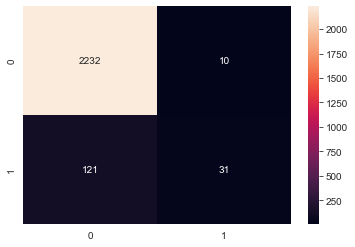

In [31]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

## plot the confusion matrix
sns.set_style('whitegrid')
cm = confusion_matrix(y_valid_t1, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [32]:
print(classification_report(y_valid_t1, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2242
           1       0.76      0.20      0.32       152

    accuracy                           0.95      2394
   macro avg       0.85      0.60      0.65      2394
weighted avg       0.94      0.95      0.93      2394



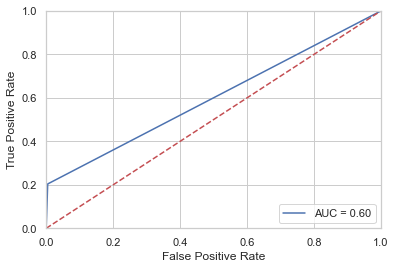

In [33]:
## plot the ROC curve
from sklearn.metrics import roc_curve, auc

sns.set_theme(style="whitegrid")
fpr, tpr, thresholds = roc_curve(y_valid_t1, y_pred)
roc_auc = auc(fpr, tpr)
sns.lineplot(x=fpr, y=tpr, label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.0,1.0])
plt.ylim([-0.0,1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [34]:
## pred the test data and save it
y_pred_test = xgbModel_best.predict_proba(X_test_t1)[::,1]
y_pred_test = pd.DataFrame(y_pred_test, columns=['Predicted'])

X_test_1 = pd.read_csv(os.path.join(path_X, 'X_test.csv'), index_col=[0], header=[0,1,2])
y_pred_test.index = X_test_1.index # set the index
y_pred_test.reset_index(inplace=True) # reset the index
y_pred_test.rename({'index':'Id'}, axis=1, inplace=True) # rename the index column
y_pred_test.to_csv(os.path.join(path_y_t1, 'y_test_v1.4.csv'), index=False)